In [1]:
# !pip install optuna

In [2]:
# !pip install ta

In [3]:
# !pip install mplfinance

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold, train_test_split, TimeSeriesSplit

from xgboost import XGBRegressor, XGBClassifier
# import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import optuna
import ta
import mplfinance as mpf

%matplotlib inline
import seaborn as sns
sns.set()

In [5]:
data = pd.read_csv('inputs/USDJPY_M15.csv', sep='\t', names=('date', 'time', 'open', 'high', 'low', 'close'), usecols=[0, 1, 2, 3, 4, 5], skiprows=1)
data['datetime'] = pd.to_datetime(data['date']  + ' ' + data['time'])
data.drop(['date', 'time'], axis=1, inplace=True)
data

,open,high,low,close,datetime
0,107.525,107.552,107.470,107.537,2020-04-01 00:00:00
1,107.537,107.555,107.514,107.540,2020-04-01 00:15:00
2,107.540,107.563,107.523,107.523,2020-04-01 00:30:00
3,107.523,107.527,107.509,107.509,2020-04-01 00:45:00
4,107.509,107.551,107.480,107.551,2020-04-01 01:00:00
...,...,...,...,...,...
27602,108.873,108.873,108.837,108.843,2021-05-11 12:45:00
27603,108.841,108.854,108.746,108.767,2021-05-11 13:00:00
27604,108.768,108.774,108.666,108.698,2021-05-11 13:15:00
27605,108.698,108.736,108.693,108.728,2021-05-11 13:30:00


In [6]:
all_data = data.copy()
all_data

,open,high,low,close,datetime
0,107.525,107.552,107.470,107.537,2020-04-01 00:00:00
1,107.537,107.555,107.514,107.540,2020-04-01 00:15:00
2,107.540,107.563,107.523,107.523,2020-04-01 00:30:00
3,107.523,107.527,107.509,107.509,2020-04-01 00:45:00
4,107.509,107.551,107.480,107.551,2020-04-01 01:00:00
...,...,...,...,...,...
27602,108.873,108.873,108.837,108.843,2021-05-11 12:45:00
27603,108.841,108.854,108.746,108.767,2021-05-11 13:00:00
27604,108.768,108.774,108.666,108.698,2021-05-11 13:15:00
27605,108.698,108.736,108.693,108.728,2021-05-11 13:30:00


In [7]:
# extract features from date
all_data['day'] = [i.day for i in all_data['datetime']]
all_data['month'] = [i.month for i in all_data['datetime']]
all_data['year'] = [i.year for i in all_data['datetime']]
all_data['day_of_week'] = [i.dayofweek for i in all_data['datetime']]
all_data['day_of_year'] = [i.dayofyear for i in all_data['datetime']]

all_data['hour'] = [i.hour for i in all_data['datetime']]
all_data['minute'] = [i.minute for i in all_data['datetime']]

all_data

,open,high,low,close,datetime,day,month,year,day_of_week,day_of_year,hour,minute
0,107.525,107.552,107.470,107.537,2020-04-01 00:00:00,1,4,2020,2,92,0,0
1,107.537,107.555,107.514,107.540,2020-04-01 00:15:00,1,4,2020,2,92,0,15
2,107.540,107.563,107.523,107.523,2020-04-01 00:30:00,1,4,2020,2,92,0,30
3,107.523,107.527,107.509,107.509,2020-04-01 00:45:00,1,4,2020,2,92,0,45
4,107.509,107.551,107.480,107.551,2020-04-01 01:00:00,1,4,2020,2,92,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27602,108.873,108.873,108.837,108.843,2021-05-11 12:45:00,11,5,2021,1,131,12,45
27603,108.841,108.854,108.746,108.767,2021-05-11 13:00:00,11,5,2021,1,131,13,0
27604,108.768,108.774,108.666,108.698,2021-05-11 13:15:00,11,5,2021,1,131,13,15
27605,108.698,108.736,108.693,108.728,2021-05-11 13:30:00,11,5,2021,1,131,13,30


In [8]:
dataset = all_data[['open', 'high', 'low', 'close', 'day', 'month', 'year', 'day_of_week', 'day_of_year', 'hour', 'minute']]
# dataset = all_data[['open', 'high', 'low', 'close']]
dataset


,open,high,low,close,day,month,year,day_of_week,day_of_year,hour,minute
0,107.525,107.552,107.470,107.537,1,4,2020,2,92,0,0
1,107.537,107.555,107.514,107.540,1,4,2020,2,92,0,15
2,107.540,107.563,107.523,107.523,1,4,2020,2,92,0,30
3,107.523,107.527,107.509,107.509,1,4,2020,2,92,0,45
4,107.509,107.551,107.480,107.551,1,4,2020,2,92,1,0
...,...,...,...,...,...,...,...,...,...,...,...
27602,108.873,108.873,108.837,108.843,11,5,2021,1,131,12,45
27603,108.841,108.854,108.746,108.767,11,5,2021,1,131,13,0
27604,108.768,108.774,108.666,108.698,11,5,2021,1,131,13,15
27605,108.698,108.736,108.693,108.728,11,5,2021,1,131,13,30


In [9]:
def classify_buy(x):
    if x > 0.05:
        return 1
    return 0

In [10]:
def classify_sell(x):
    if x < -0.05:
        return 2
    return 0

In [11]:
diff_HC = dataset['high'].shift(-1) - dataset['close']
diff_LC = dataset['low'].shift(-1) - dataset['close']
dataset['y'] = diff_HC.apply(classify_buy)
dataset['y'] += diff_LC.apply(classify_sell)
dataset['y'] = dataset['y'].apply(lambda x: 0 if x == 3 else x)
dataset[['y', 'open', 'high', 'low', 'close']][290:310]

,y,open,high,low,close
290,0,108.413,108.443,108.411,108.416
291,1,108.416,108.432,108.411,108.420
292,2,108.420,108.585,108.418,108.514
293,0,108.514,108.514,108.401,108.443
294,0,108.443,108.482,108.397,108.441
295,1,108.441,108.473,108.419,108.457
296,1,108.457,108.608,108.454,108.599
297,2,108.600,108.673,108.572,108.672
298,0,108.671,108.671,108.595,108.629
299,1,108.629,108.739,108.575,108.712


In [12]:
dataset['y'].value_counts()

0    19861
2     3924
1     3822
Name: y, dtype: int64

In [13]:
def objective(trial):
    # X = dataset2.drop(['y'], axis=1)
    # y = dataset2['y']

    _X_train, _X_test, _y_train, _y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # folds = KFold(n_splits = 5, shuffle = True)
    # folds = TimeSeriesSplit(n_splits = 8)

    # params = {'objective': ['reg:squarederror'], 'max_depth': list(range(2, 10)), 'random_state': [0], 'n_estimators': list(range(50, 200, 50)), 'learning_rate': [0.1, 0.01, 0.001]}
    # params = {'objective': ['reg:squarederror'], 'random_state': [0], 'learning_rate': [0.1, 0.01, 0.001]}
    # params = {'objective': ['reg:squarederror'], 'max_depth': list(range(2, 10)), 'random_state': [0]}
    # params = {'objective': ['reg:squarederror'], 'random_state': [0], 'n_estimators': list(range(50, 200, 50))}
    # params = {'objective': ['reg:squarederror'], 'max_depth': list(range(2, 10)), 'random_state': [0], 'n_estimators': list(range(50, 200, 50))}
#     boosting_list = ['gbtree', 'gblinear']
    objective_list_reg = ['reg:linear', 'reg:gamma', 'reg:tweedie']
    metric_list = ['rmse']

    params = {
#         'boosting':trial.suggest_categorical('boosting', boosting_list),
#         'tree_method': 'gpu_hist',
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
        'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
        'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
        'gamma':trial.suggest_int('gamma', 0, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'eval_metric':trial.suggest_categorical('eval_metric', metric_list),
        'objective':trial.suggest_categorical('objective', objective_list_reg),
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree', 0.1, 1, 0.01),
        'colsample_bynode':trial.suggest_discrete_uniform('colsample_bynode', 0.1, 1, 0.01),
        'colsample_bylevel':trial.suggest_discrete_uniform('colsample_bylevel', 0.1, 1, 0.01),
        'subsample':trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.05),
        'nthread' : -1
        }

    # XGBoost
    # xgb = XGBRegressor(tree_method='gpu_hist')
    # xgb = XGBRegressor()
    # xgb = XGBRegressor(**params)
    xgb = XGBClassifier(**params)

    # reg_cv_xgb = GridSearchCV(xgb, params, cv=folds, return_train_score=True)
    # reg_cv_xgb.fit(X_train, y_train)
    xgb.fit(_X_train, _y_train)

    # print(reg_cv_xgb.best_params_)
    # y_pred = reg_cv_xgb.predict(_X_val)
    y_pred = xgb.predict(_X_test)

    # y_ = np.concatenate([np.array([None for i in range(len(y_train))]) , y_pred])
    # y_ = pd.DataFrame(y_, index=X.index)

    # plt.figure(figsize=(16,5))
    # plt.plot(y, label='original')
    # plt.plot(y_, '--', label='predict')
    # plt.legend()
    # plt.show()

    # plt.figure(figsize=(16,5))
    # plt.plot(y[-50:], label='original')
    # plt.plot(y_[-50:], '--', label='predict')
    # plt.legend()
    # plt.show()

    # return np.sqrt(mean_squared_error(y_val, y_pred))
    return 1 - accuracy_score(_y_test, y_pred)

In [14]:
dataset2 = dataset.copy()

# for i in range(1, 13):
#     dataset2['shift%s'%i] = dataset2['close'].shift(i)

# sma
sma5 = ta.trend.SMAIndicator(dataset['close'], 5)
sma20 = ta.trend.SMAIndicator(dataset['close'], 20)
dataset2['sma5_close'] = sma5.sma_indicator() / dataset2['close']
dataset2['sma20_close'] = sma20.sma_indicator() / dataset2['close']

# rsi
rsi14 = ta.momentum.RSIIndicator(dataset['close'], 14)
dataset2['rsi14_rsi'] = rsi14.rsi()

# macd
macd = ta.trend.MACD(dataset2['close'])
dataset2['macd_macd'] = macd.macd()

# bollinger bands
bband = ta.volatility.BollingerBands(dataset2['close'])
dataset2['bband_+2a'] = bband.bollinger_hband() / dataset2['close']
dataset2['bband_-2z'] = bband.bollinger_lband() / dataset2['close']

dataset2 = dataset2.dropna()
dataset2

,open,high,low,close,day,month,year,day_of_week,day_of_year,hour,minute,y,sma5_close,sma20_close,rsi14_rsi,macd_macd,bband_+2a,bband_-2z
25,107.684,107.742,107.642,107.702,1,4,2020,2,92,6,15,1,1.000245,0.999025,56.171987,0.055236,1.001992,0.996057
26,107.702,107.845,107.659,107.790,1,4,2020,2,92,6,30,0,0.999438,0.998294,60.827529,0.060864,1.001360,0.995228
27,107.791,107.822,107.758,107.791,1,4,2020,2,92,6,45,0,0.999451,0.998298,60.878384,0.064660,1.001390,0.995205
28,107.791,107.830,107.757,107.780,1,4,2020,2,92,7,0,0,0.999716,0.998458,59.956304,0.066019,1.001625,0.995291
29,107.780,107.820,107.731,107.732,1,4,2020,2,92,7,15,0,1.000251,0.999054,55.972369,0.062503,1.002129,0.995978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27602,108.873,108.873,108.837,108.843,11,5,2021,1,131,12,45,2,1.000068,1.000324,45.831825,-0.003790,1.000985,0.999664
27603,108.841,108.854,108.746,108.767,11,5,2021,1,131,13,0,2,1.000662,1.000999,38.045058,-0.011754,1.001764,1.000235
27604,108.768,108.774,108.666,108.698,11,5,2021,1,131,13,15,0,1.000970,1.001572,32.625462,-0.023364,1.002609,1.000536
27605,108.698,108.736,108.693,108.728,11,5,2021,1,131,13,30,0,1.000495,1.001242,36.838341,-0.029801,1.002421,1.000064


In [15]:
# X = dataset2.drop(['y', 'close', 'low', 'high', 'open'], axis=1)
X = dataset2.drop(['y'], axis=1)
y = dataset2['y']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# feature_importance_model = RandomForestRegressor(random_state=0)
feature_importance_model = RandomForestClassifier(random_state=0)
feature_importance_model.fit(X, y)

RandomForestClassifier(random_state=0)

[Text(0, 0, 'sma5_close'),
 Text(1, 0, 'bband_-2z'),
 Text(2, 0, 'bband_+2a'),
 Text(3, 0, 'sma20_close'),
 Text(4, 0, 'macd_macd'),
 Text(5, 0, 'rsi14_rsi'),
 Text(6, 0, 'hour'),
 Text(7, 0, 'high'),
 Text(8, 0, 'low'),
 Text(9, 0, 'close'),
 Text(10, 0, 'open'),
 Text(11, 0, 'day_of_year'),
 Text(12, 0, 'day'),
 Text(13, 0, 'minute'),
 Text(14, 0, 'day_of_week'),
 Text(15, 0, 'month'),
 Text(16, 0, 'year')]

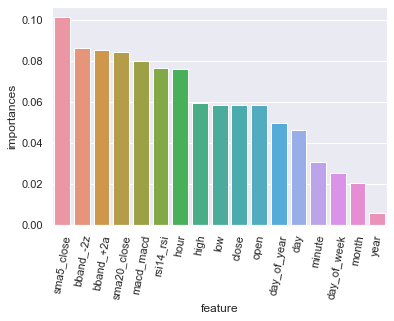

In [16]:
f = pd.DataFrame({"feature":X.columns,"importances":feature_importance_model.feature_importances_})
f = f.sort_values(by="importances",ascending=False) #並び替え

g = sns.barplot(x="feature",y="importances",data=f)
g.set_xticklabels(f["feature"],rotation=80)

In [ ]:
X = dataset2.drop(['y'], axis=1)
y = dataset2['y']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# folds = KFold(n_splits = 5, shuffle = True)
# folds = TimeSeriesSplit(n_splits = 8)

study = optuna.create_study()
study.optimize(objective, n_trials=100)


[I 2021-05-12 19:43:24,411] A new study created in memory with name: no-name-7eecb282-877a-4247-bd38-9681fc722761
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-05-12 19:43:28,188] Trial 0 finished with value: 0.20643553138454562 and parameters: {'max_depth': 3, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 4, 'gamma': 2, 'learning_rate': 0.001434404691986216, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.52, 'colsample_bynode': 0.23, 'colsample_bylevel': 0.45000000000000007, 'subsample': 0.9}. Best is trial 0 with value: 0.20643553138454562.
D:\Anaconda3\lib

[I 2021-05-12 19:44:59,462] Trial 9 finished with value: 0.20643553138454562 and parameters: {'max_depth': 13, 'reg_alpha': 3, 'reg_lambda': 0, 'min_child_weight': 3, 'gamma': 3, 'learning_rate': 3.6571940914992696e-08, 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'colsample_bytree': 0.45999999999999996, 'colsample_bynode': 0.42000000000000004, 'colsample_bylevel': 0.88, 'subsample': 0.65}. Best is trial 0 with value: 0.20643553138454562.
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-05-12 19:45:01,921] Trial 10 finished with value: 0.20643553138454562 and parameters: {'max_depth': 2,

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-05-12 19:45:44,383] Trial 19 finished with value: 0.20643553138454562 and parameters: {'max_depth': 18, 'reg_alpha': 5, 'reg_lambda': 4, 'min_child_weight': 5, 'gamma': 2, 'learning_rate': 2.693081437465424e-07, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.27, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.64, 'subsample': 0.7}. Best is trial 0 with value: 0.20643553138454562.
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed

[I 2021-05-12 19:47:11,334] Trial 28 finished with value: 0.30274189893496484 and parameters: {'max_depth': 15, 'reg_alpha': 5, 'reg_lambda': 2, 'min_child_weight': 5, 'gamma': 0, 'learning_rate': 0.0002596768165364894, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.96, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.84, 'subsample': 1.0}. Best is trial 0 with value: 0.20643553138454562.
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-05-12 19:47:18,784] Trial 29 finished with value: 0.20643553138454562 and parameters: {'max_depth': 12, 'reg_alpha': 2, 'reg_lambda': 1

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-05-12 19:48:45,063] Trial 38 finished with value: 0.2066621346023113 and parameters: {'max_depth': 19, 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 4, 'gamma': 1, 'learning_rate': 0.007079298516943196, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.54, 'colsample_bynode': 0.31, 'colsample_bylevel': 0.2, 'subsample': 1.0}. Best is trial 0 with value: 0.20643553138454562.
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed i

[I 2021-05-12 19:50:09,414] Trial 47 finished with value: 0.2071153410378428 and parameters: {'max_depth': 9, 'reg_alpha': 3, 'reg_lambda': 3, 'min_child_weight': 1, 'gamma': 3, 'learning_rate': 5.010161975135487e-05, 'eval_metric': 'rmse', 'objective': 'reg:gamma', 'colsample_bytree': 0.62, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.79, 'subsample': 0.8}. Best is trial 0 with value: 0.20643553138454562.
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-05-12 19:50:12,871] Trial 48 finished with value: 0.20643553138454562 and parameters: {'max_depth': 2, 'reg_alpha': 4, 'reg

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-05-12 19:51:48,939] Trial 57 finished with value: 0.2293224563788806 and parameters: {'max_depth': 16, 'reg_alpha': 2, 'reg_lambda': 2, 'min_child_weight': 3, 'gamma': 0, 'learning_rate': 0.06430287372329488, 'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.36, 'colsample_bynode': 0.13, 'colsample_bylevel': 0.38, 'subsample': 0.95}. Best is trial 0 with value: 0.20643553138454562.
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed 

In [ ]:
print(study.best_params)
print(study.best_value)
print(study.best_trial)


In [ ]:
xgb_ = XGBClassifier(**study.best_params)

In [ ]:
xgb_.fit(X_train, y_train)

In [ ]:
y_pred = xgb_.predict(X_val)
accuracy_score(y_val, y_pred)

In [ ]:
verify = X_val.copy()
verify['y_pred'] = y_pred
verify['y'] = y_val
verify

In [ ]:
verify[verify['y_pred'] != verify['y']]

In [ ]:
np.unique(y_pred)

In [ ]:
verify['y'].value_counts()

In [ ]:
# save to JSON
xgb_.save_model("model_v2.json")